# Model - CIC IoT 2023 Dataset for Cybersecurity Research

[University of New Brunswick - Canadian Institute for Cybersecurity](https://www.unb.ca/cic/datasets/index.html)

TODOs:
- Test adding a feature indicating the highest protocol layer
- Test adding a feature of % of control packets

# Imports

In [1]:
import os
import sys
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from IPython.display import HTML

sys.path.append('../')
n_jobs = 40

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier

## Definitions

In [3]:
import utils
import model_utils
import visualization as viz

from multi_stage_classifier import MultiStageClassifier, ModelStage

constants = utils.get_constants()
seed = constants['seed']

parquet_path = constants['parquet_path']
refined_parquet_path = constants['refined_parquet_path']

features = constants['features']
protocol_layer = constants['protocol_layer']
protocol_layer_map = constants['protocol_layer_map']
attack_category = constants['attack_category']
attack_category_map = constants['attack_category_map']

## Read datasets

In [4]:
df = pd.read_parquet(parquet_path)
df_refined = pd.read_parquet(refined_parquet_path)

features_list = utils.get_features_list(df)
refined_features_list = utils.get_features_list(df_refined)

# features_list.remove('Protocol Type')
# refined_features_list.remove('Protocol Type')

# Model (2 Stages)

In [5]:
simplified_first_layer_labels = {'DDoS', 'DoS', 'Mirai'}
simplified_second_layer_labels = {'Spoofing', 'Recon', 'Web', 'BruteForce'}

first_layer_labels = {
    attack_type
    for layer_attack in simplified_first_layer_labels
    for attack_type in attack_category[layer_attack]
}

second_layer_labels = {
    attack_type
    for layer_attack in simplified_second_layer_labels
    for attack_type in attack_category[layer_attack]
}

## First Stage - DDoS / DoS / Mirai

Here we focus on recall... **TODO: Explain why**

### 33+1 Attacks

In [6]:
%%time

first_stage_labels = (
    df_refined.label
    .where(df_refined.label.isin(first_layer_labels), 'BenignTraffic')
    .astype('category')
    .cat.remove_unused_categories()
)

first_stage_df_split = model_utils.get_train_test_split(
    df_refined,
    target=first_stage_labels,
    sample_size=5_000_000,
    train_frac=0.80
)

Training dataset size: 4.0M (80.0%).
Test dataset size: 1.0M (20.0%).
CPU times: user 15.8 s, sys: 3.85 s, total: 19.6 s
Wall time: 19.1 s


#### Search Hyperparameters

In [7]:
%%time

simplified_first_stage_model = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'class_weight': ['balanced', None]
}

grid_search = GridSearchCV(
    estimator=simplified_first_stage_model,
    param_grid=param_grid,
    cv=5,
    n_jobs=n_jobs,
    verbose=1
)

X_train, X_test, y_train, y_test = first_stage_df_split
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'splitter': 'best'}
Best Cross-Validation Score: 0.9998468
CPU times: user 2min 55s, sys: 7.93 s, total: 3min 3s
Wall time: 5min 56s


#### 1st Stage Model

Execution time (Model fit): 0:01:49.439423
Execution time (Predict): 0:00:00.302463
                         precision    recall  f1-score   support

          BenignTraffic     0.9997    0.9997    0.9997     42245
 DDoS-ACK_Fragmentation     0.9994    0.9992    0.9993      6157
        DDoS-HTTP_Flood     0.9936    0.9874    0.9905       633
        DDoS-ICMP_Flood     1.0000    1.0000    1.0000    154199
DDoS-ICMP_Fragmentation     0.9995    0.9997    0.9996      9834
      DDoS-PSHACK_Flood     1.0000    1.0000    1.0000     87925
       DDoS-RSTFINFlood     1.0000    1.0000    1.0000     86699
         DDoS-SYN_Flood     0.9998    0.9999    0.9999     86616
         DDoS-SlowLoris     0.9941    0.9961    0.9951       508
DDoS-SynonymousIP_Flood     0.9999    0.9999    0.9999     77245
         DDoS-TCP_Flood     0.9999    1.0000    1.0000     96531
         DDoS-UDP_Flood     0.9998    0.9998    0.9998    115943
 DDoS-UDP_Fragmentation     0.9994    0.9989    0.9991      6259
     

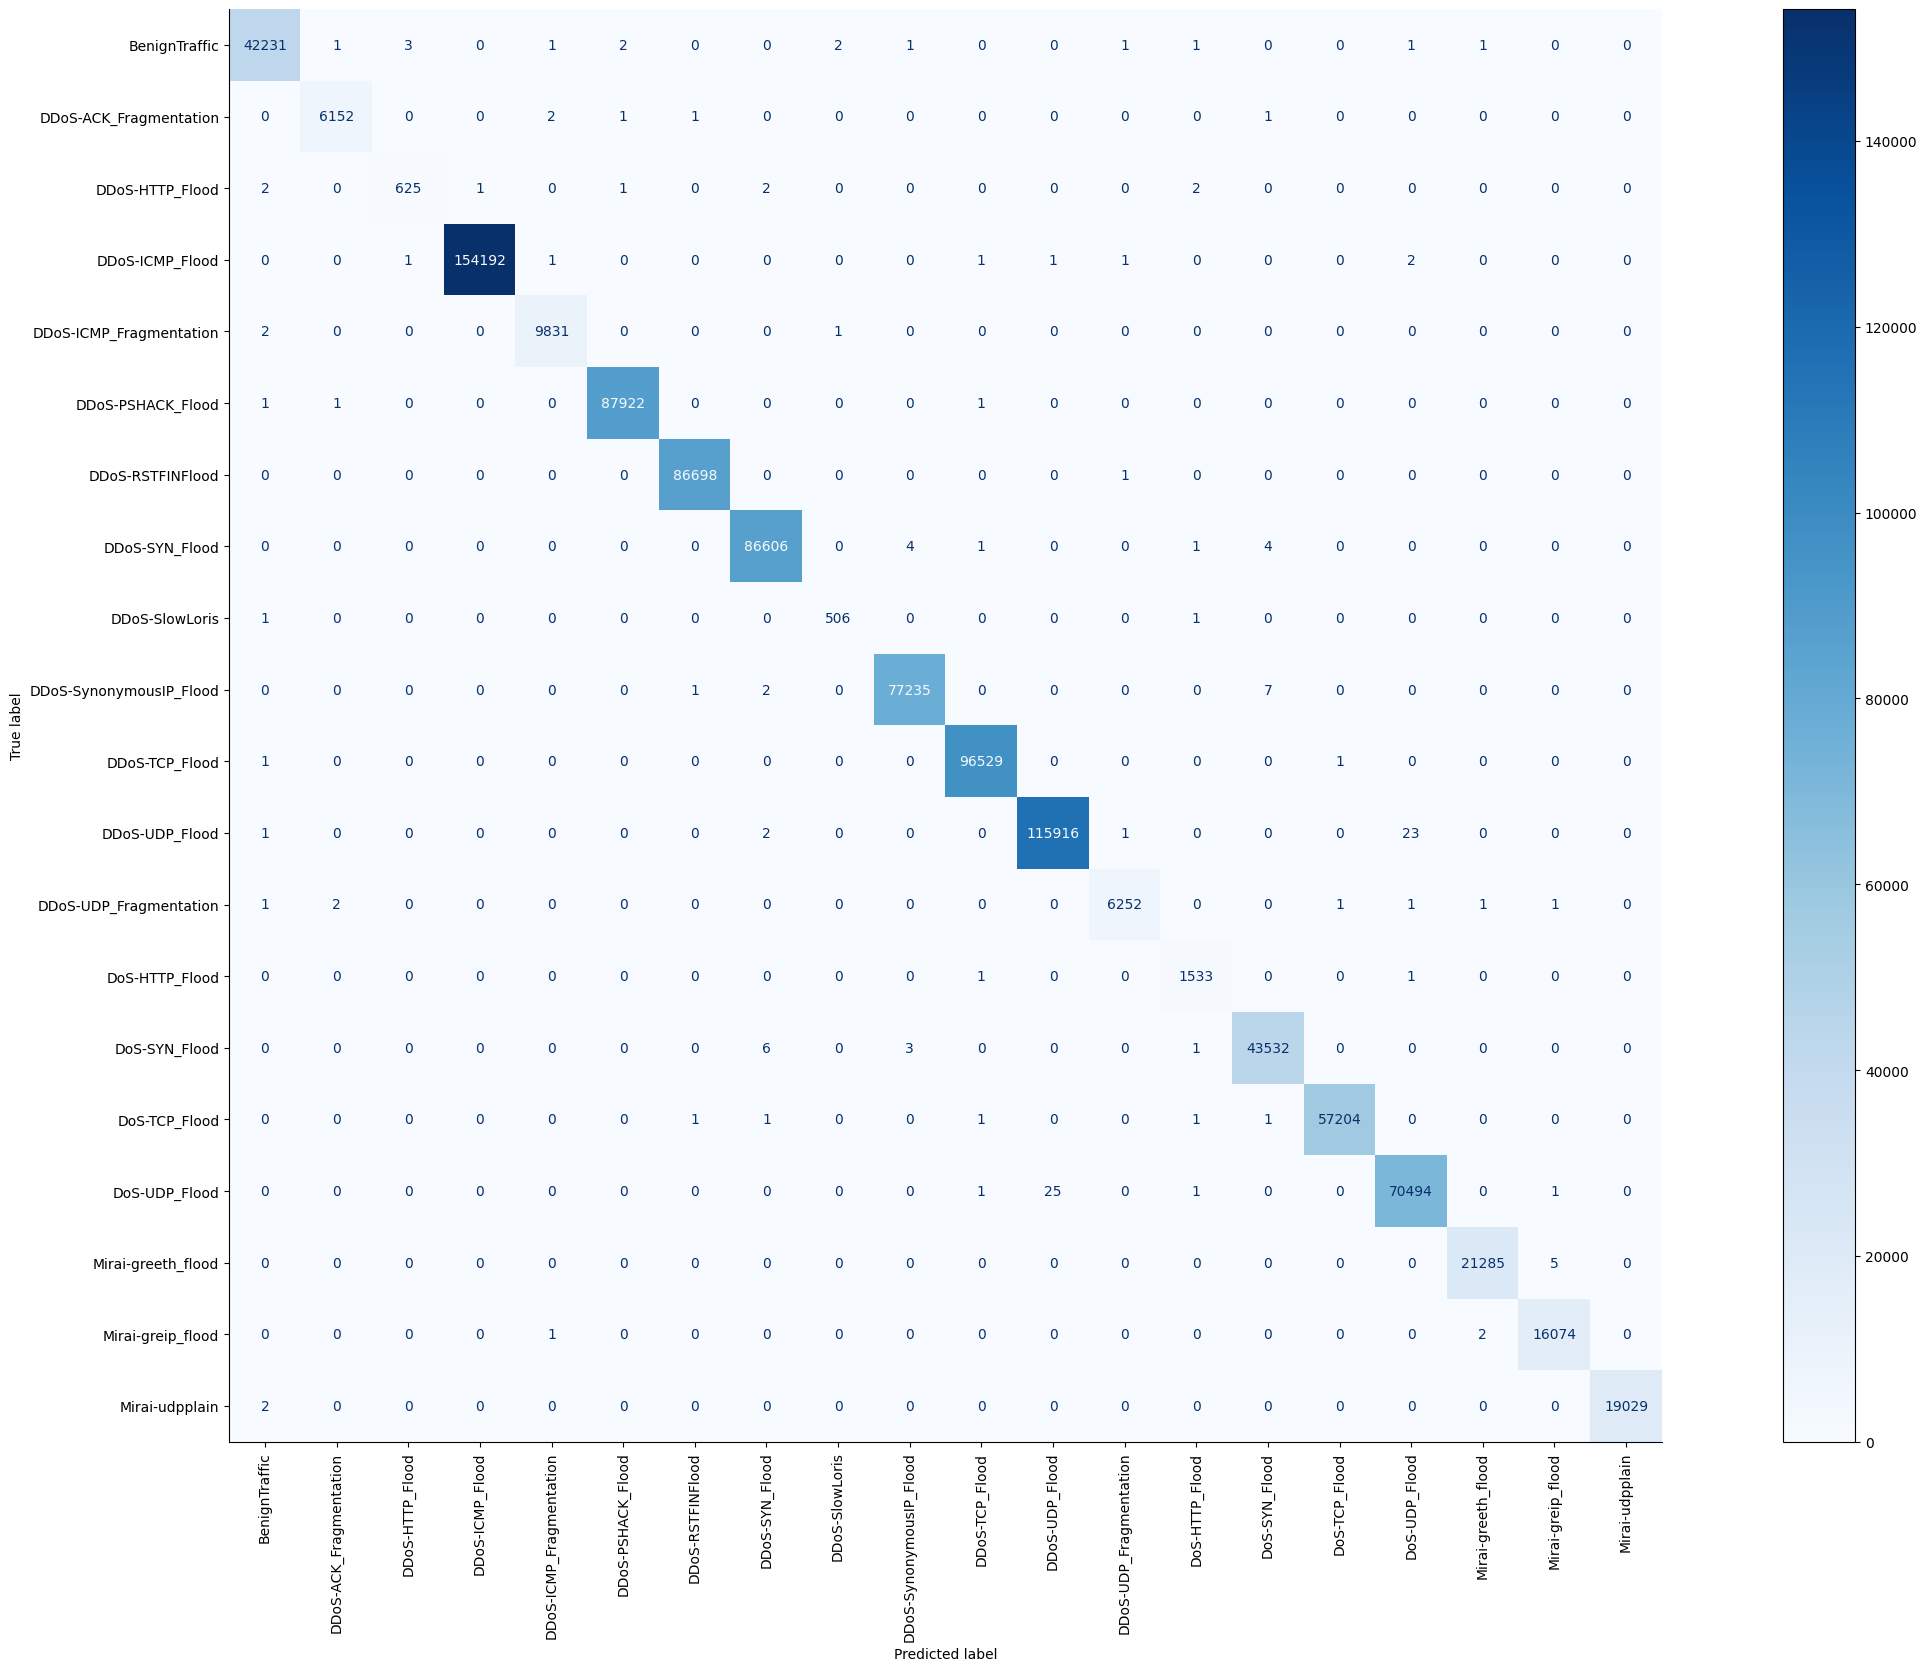

In [38]:
%%time

first_stage_model = DecisionTreeClassifier(
    criterion='entropy',
    class_weight='balanced',
    random_state=seed
)

X_train, X_test, y_train, y_test = first_stage_df_split

model_utils.train_model(first_stage_model, X_train, y_train)
model_utils.evaluate_model(first_stage_model, X_test, y_test)

### 7+1 Attacks

In [8]:
%%time

simplified_first_stage_labels = (
    df_refined.general_label
    .where(df_refined.general_label.isin(simplified_first_layer_labels), 'Benign')
    .astype('category')
    .cat.remove_unused_categories()
)

simplified_first_stage_df_split = model_utils.get_train_test_split(
    df_refined,
    target=simplified_first_stage_labels,
    sample_size=5_000_000,
    train_frac=0.80
)

Training dataset size: 4.0M (80.0%).
Test dataset size: 1.0M (20.0%).
CPU times: user 15.6 s, sys: 4.42 s, total: 20 s
Wall time: 20 s


Execution time (Model fit): 0:01:16.694944
Execution time (Predict): 0:00:00.298093
              precision    recall  f1-score   support

      Benign     0.9998    0.9997    0.9998     42135
        DDoS     0.9999    0.9999    0.9999    728225
         DoS     0.9997    0.9998    0.9997    173224
       Mirai     1.0000    0.9999    1.0000     56416

    accuracy                         0.9999   1000000
   macro avg     0.9999    0.9998    0.9999   1000000
weighted avg     0.9999    0.9999    0.9999   1000000

CPU times: user 1min 22s, sys: 1.17 s, total: 1min 23s
Wall time: 1min 22s


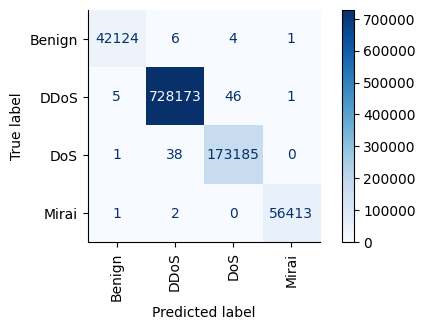

In [37]:
%%time

simplified_first_stage_model = DecisionTreeClassifier(
    criterion='entropy',
    class_weight='balanced',
    random_state=seed
)

X_train, X_test, y_train, y_test = simplified_first_stage_df_split

model_utils.train_model(simplified_first_stage_model, X_train, y_train)
model_utils.evaluate_model(simplified_first_stage_model, X_test, y_test)

## Second Stage - Spoofing / Recon / Web / Brute Force

In [12]:
df_second_stage = df_refined[~df_refined.general_label.isin(simplified_first_layer_labels)]

### 33 + 1 Attacks

In [34]:
%%time

second_stage_target = (
    df_second_stage.label
    .where(df_second_stage.label.isin(second_layer_labels), 'BenignTraffic')
    .astype('category')
    .cat.remove_unused_categories()
)

second_stage_df_split = model_utils.get_train_test_split(
    df_second_stage,
    target=second_stage_target,
    train_frac=0.80
)

Training dataset size: 1.6M (80.0%).
Test dataset size: 395.4k (20.0%).
CPU times: user 1.73 s, sys: 190 ms, total: 1.92 s
Wall time: 1.92 s


Execution time (Model fit): 0:03:21.657608
Execution time (Predict): 0:00:02.268991
                      precision    recall  f1-score   support

    Backdoor_Malware     0.9008    0.5540    0.6860       639
       BenignTraffic     0.9078    0.9897    0.9470    219566
    BrowserHijacking     0.9682    0.6280    0.7619      1164
    CommandInjection     0.9688    0.5892    0.7327      1054
        DNS_Spoofing     0.8735    0.7836    0.8261     36020
DictionaryBruteForce     0.9651    0.6441    0.7726      2616
    MITM-ArpSpoofing     0.9459    0.8672    0.9048     61773
 Recon-HostDiscovery     0.8796    0.8910    0.8853     26660
        Recon-OSScan     0.8926    0.6535    0.7546     19563
     Recon-PingSweep     0.9489    0.5462    0.6933       476
      Recon-PortScan     0.8589    0.6974    0.7698     16367
        SqlInjection     0.9539    0.5704    0.7139       980
   VulnerabilityScan     0.9839    0.4980    0.6612       245
                 XSS     1.0000    0.9999    0.

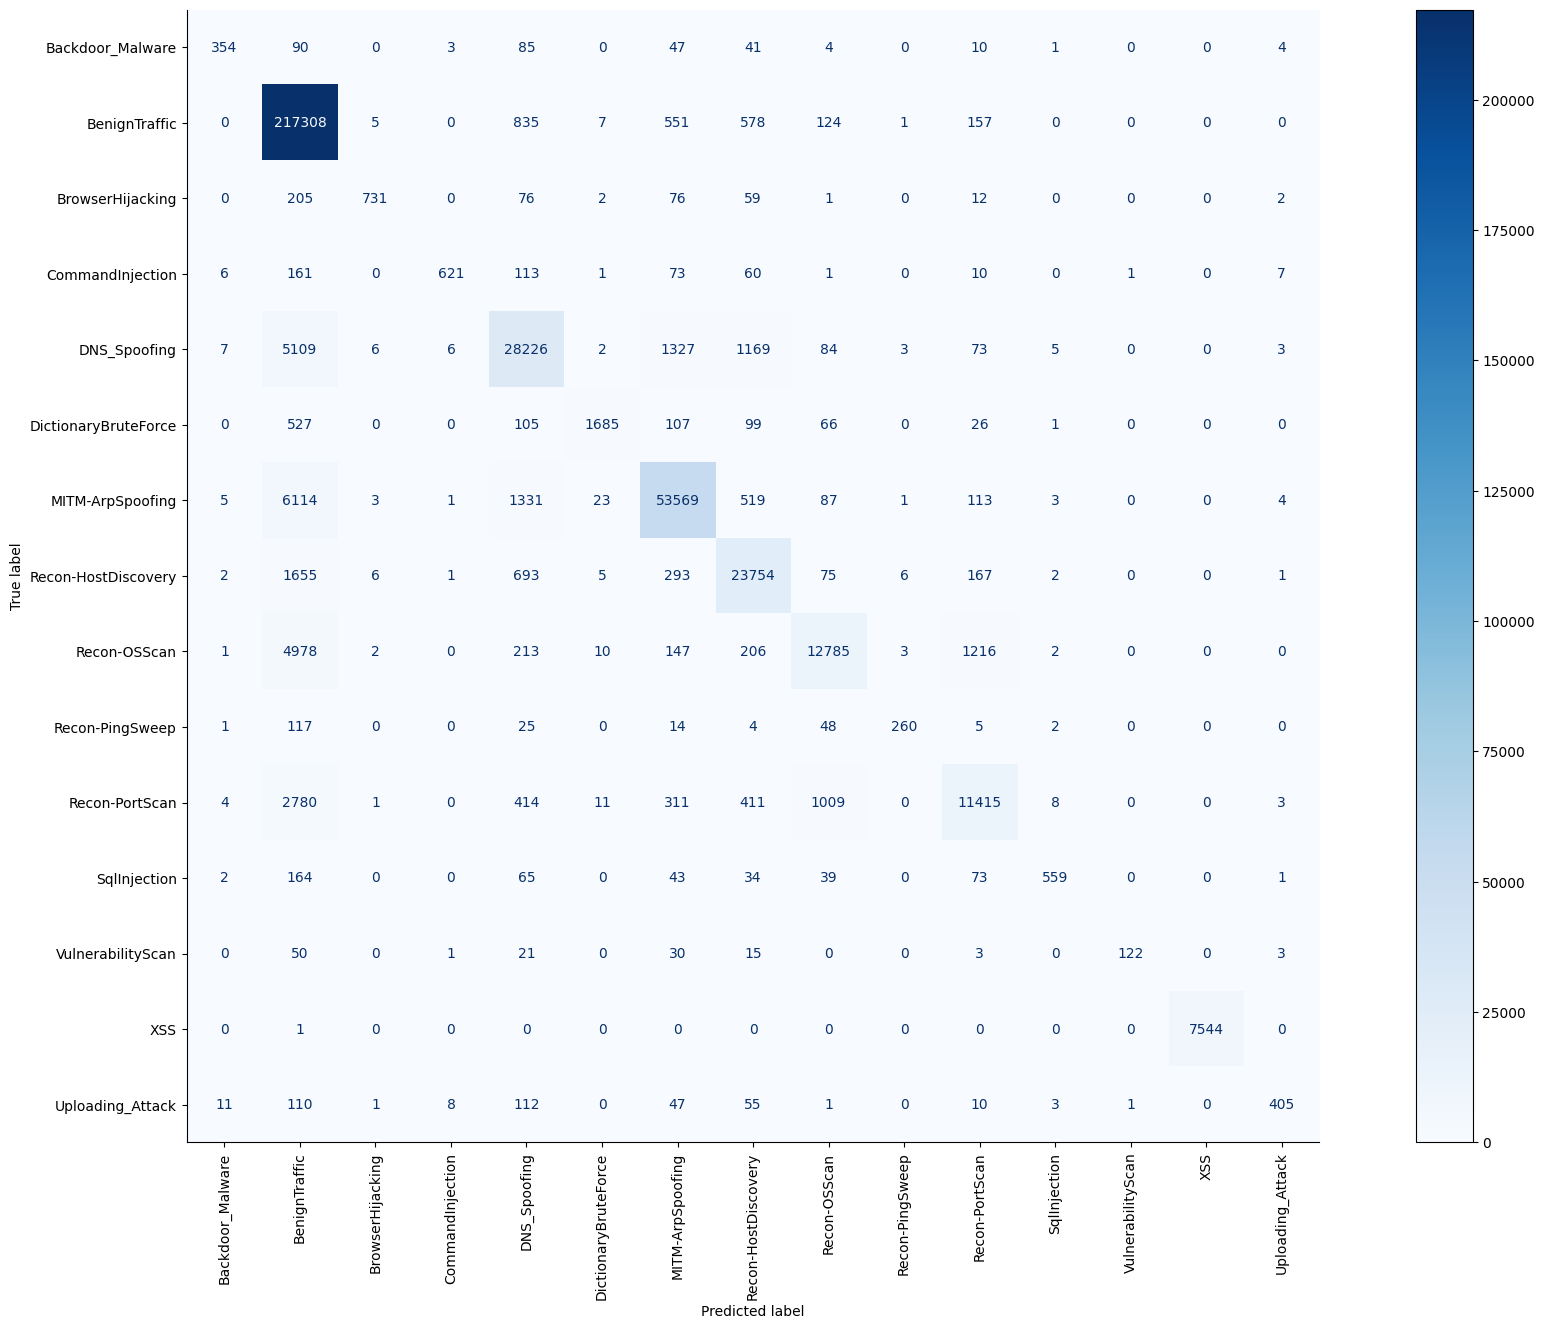

In [35]:
%%time

second_stage_model = RandomForestClassifier(
    max_features=12,
    # bootstrap=False,
    criterion='entropy',
    class_weight='balanced',
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = second_stage_df_split

model_utils.train_model(second_stage_model, X_train, y_train)
model_utils.evaluate_model(second_stage_model, X_test, y_test)

### 7 + 1 Attacks

In [17]:
%%time

simplified_second_layer_target = (
    df_second_stage.general_label
    .where(df_second_stage.general_label.isin(simplified_second_layer_labels), 'Benign')
    .astype('category')
    .cat.remove_unused_categories()
)

simplified_second_stage_df_split = model_utils.get_train_test_split(
    df_second_stage,
    target=simplified_second_layer_target,
    train_frac=0.80
)

Training dataset size: 1.6M (80.0%).
Test dataset size: 395.4k (20.0%).
CPU times: user 1.48 s, sys: 295 ms, total: 1.77 s
Wall time: 1.77 s


Execution time (Model fit): 0:02:23.154855
Execution time (Predict): 0:00:01.567575
              precision    recall  f1-score   support

      Benign     0.9298    0.9815    0.9550    219566
  BruteForce     0.9785    0.6422    0.7754      2616
       Recon     0.9186    0.8649    0.8909     70611
    Spoofing     0.9341    0.8833    0.9080     97793
         Web     0.9609    0.5929    0.7333      4846

    accuracy                         0.9294    395432
   macro avg     0.9444    0.7929    0.8525    395432
weighted avg     0.9294    0.9294    0.9294    395432

CPU times: user 1h 8min 41s, sys: 5.07 s, total: 1h 8min 46s
Wall time: 2min 26s


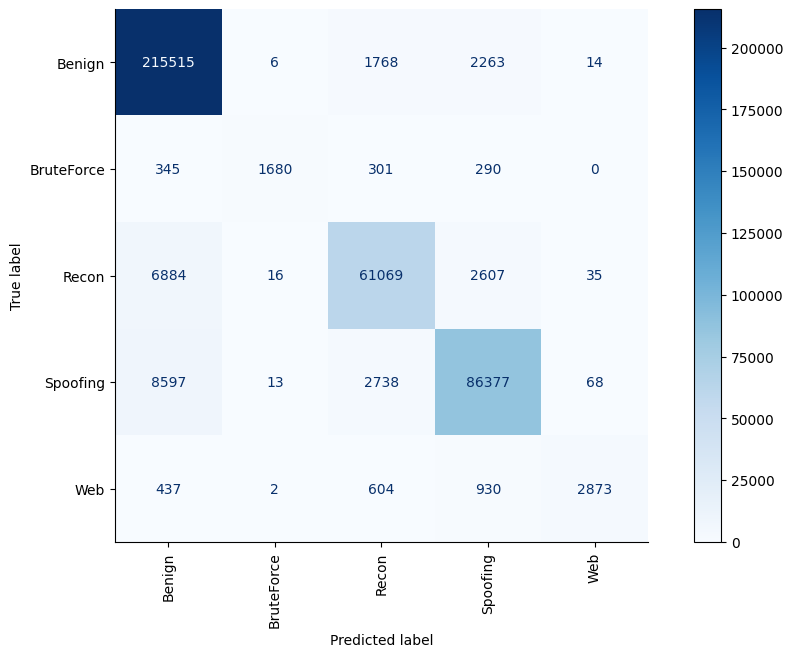

In [28]:
%%time

simplified_second_stage_model = RandomForestClassifier(
    class_weight='balanced',
    criterion='entropy',
    max_features=12,
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = simplified_second_stage_df_split

model_utils.train_model(simplified_second_stage_model, X_train, y_train)
model_utils.evaluate_model(simplified_second_stage_model, X_test, y_test)

# Multi-Stage Model

### 33+1 Attacks

In [29]:
%%time

multi_stage_df_split = model_utils.get_train_test_split(
    df_refined,
    target='label',
    sample_size=10_000_000,
    train_frac=0.80
)

Training dataset size: 8.0M (80.0%).
Test dataset size: 2.0M (20.0%).
CPU times: user 23.2 s, sys: 3.33 s, total: 26.6 s
Wall time: 26.5 s


Execution time (Model fit): 0:04:17.720459
Execution time (Predict): 0:00:02.861684
                         precision    recall  f1-score   support

       Backdoor_Malware     0.9730    0.5070    0.6667       142
          BenignTraffic     0.8942    0.9897    0.9395     47044
       BrowserHijacking     0.9938    0.6075    0.7541       265
       CommandInjection     0.9710    0.5776    0.7243       232
 DDoS-ACK_Fragmentation     0.9995    0.9994    0.9995     12097
        DDoS-HTTP_Flood     0.9984    0.9921    0.9952      1266
        DDoS-ICMP_Flood     1.0000    1.0000    1.0000    308187
DDoS-ICMP_Fragmentation     0.9997    0.9997    0.9997     19285
      DDoS-PSHACK_Flood     1.0000    1.0000    1.0000    175640
       DDoS-RSTFINFlood     1.0000    1.0000    1.0000    173545
         DDoS-SYN_Flood     0.9999    0.9999    0.9999    174001
         DDoS-SlowLoris     0.9971    0.9990    0.9980      1015
DDoS-SynonymousIP_Flood     0.9998    0.9999    0.9999    154129
     

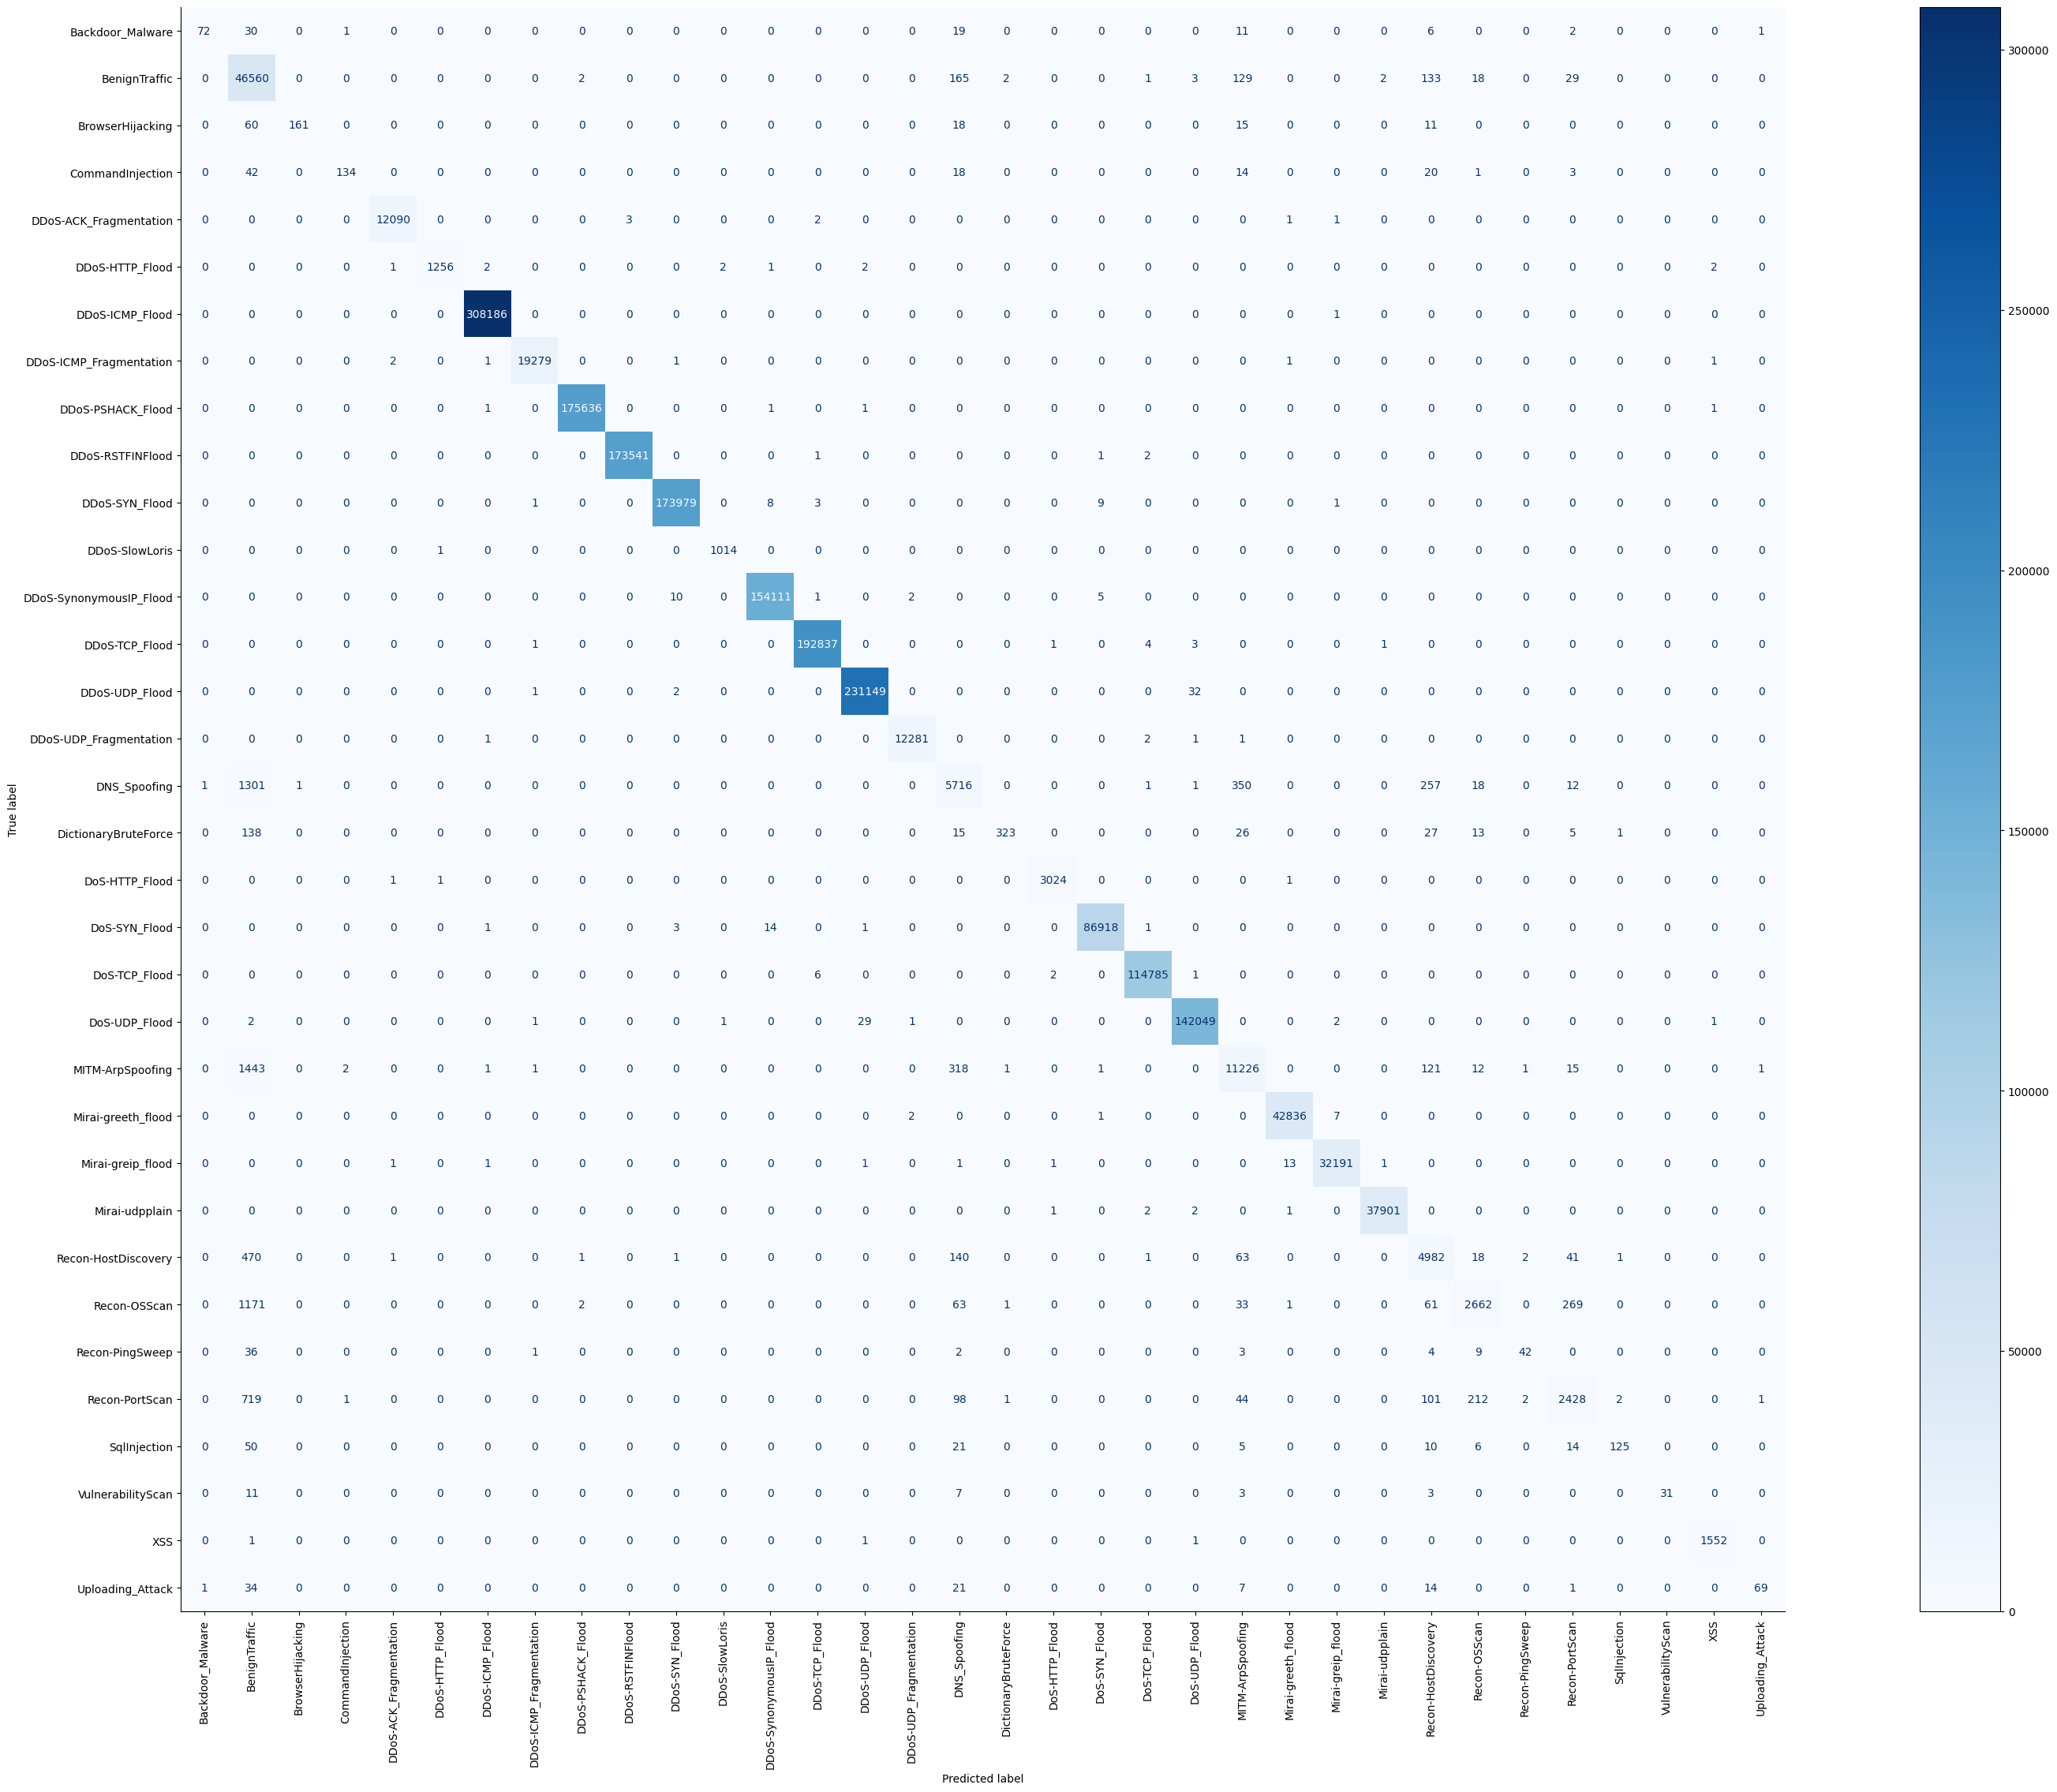

In [39]:
%%time
multi_stage_baseline_model = MultiStageClassifier(
    stages=[
        ModelStage(first_stage_model, labels=first_layer_labels),
        ModelStage(second_stage_model, labels=second_layer_labels),
    ],
    default_label='BenignTraffic'
)

X_train, X_test, y_train, y_test = multi_stage_df_split

model_utils.train_model(multi_stage_baseline_model, X_train, y_train)
model_utils.evaluate_model(multi_stage_baseline_model, X_test, y_test)

### 7+1 Attacks

In [31]:
%%time

simplified_multi_stage_df_split = model_utils.get_train_test_split(
    df_refined,
    target='general_label',
    sample_size=10_000_000,
    train_frac=0.80
)

Training dataset size: 8.0M (80.0%).
Test dataset size: 2.0M (20.0%).
CPU times: user 23.8 s, sys: 3.35 s, total: 27.1 s
Wall time: 27.1 s


Execution time (Model fit): 0:03:37.533994
Execution time (Predict): 0:00:02.049644
              precision    recall  f1-score   support

      Benign     0.9203    0.9803    0.9493     46918
  BruteForce     0.9938    0.5993    0.7477       539
        DDoS     1.0000    0.9999    0.9999   1456123
         DoS     0.9997    0.9998    0.9998    346856
       Mirai     0.9999    0.9999    0.9999    112218
       Recon     0.9094    0.8521    0.8798     15257
    Spoofing     0.9298    0.8673    0.8974     20954
         Web     0.9666    0.5604    0.7094      1135

    accuracy                         0.9966   2000000
   macro avg     0.9649    0.8574    0.8979   2000000
weighted avg     0.9966    0.9966    0.9966   2000000

CPU times: user 15min 37s, sys: 3.46 s, total: 15min 40s
Wall time: 3min 51s


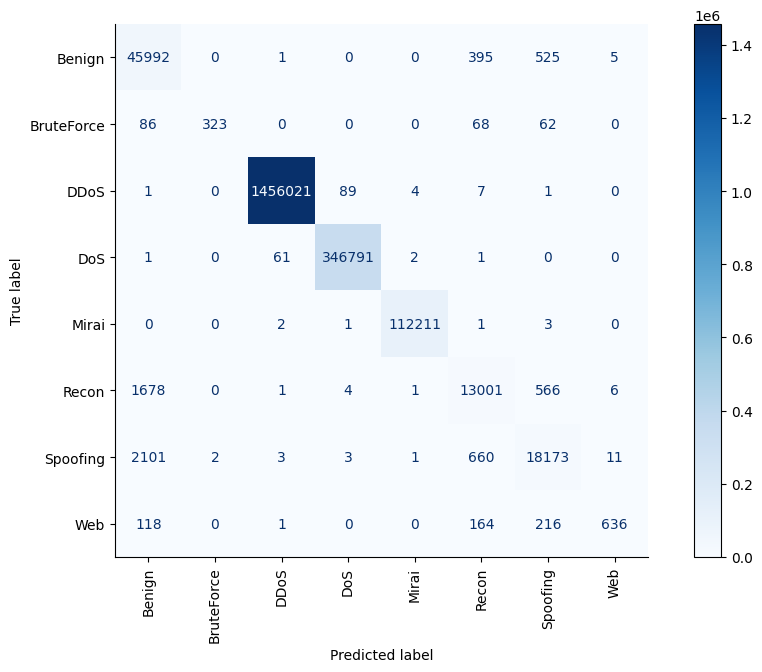

In [40]:
%%time
simplified_multi_stage_baseline_model = MultiStageClassifier(
    stages=[
        ModelStage(simplified_first_stage_model, labels=simplified_first_layer_labels),
        ModelStage(simplified_second_stage_model, labels=simplified_second_layer_labels),
    ]
)

X_train, X_test, y_train, y_test = simplified_multi_stage_df_split

model_utils.train_model(simplified_multi_stage_baseline_model, X_train, y_train)
model_utils.evaluate_model(simplified_multi_stage_baseline_model, X_test, y_test)

# Open questions from the EDA

## Simple baseline

In [10]:
%%time

test_df_split = model_utils.get_train_test_split(
    df,
    target='general_label',
    sample_size=5_000_000,
    train_frac=0.80
)

Training dataset size: 4.0M (80.0%).
Test dataset size: 1.0M (20.0%).
CPU times: user 15 s, sys: 4.28 s, total: 19.3 s
Wall time: 19.3 s


Execution time (Model fit): 0:01:26.064270
Execution time (Predict): 0:00:02.862032
              precision    recall  f1-score   support

      Benign     0.9153    0.9753    0.9444     23650
  BruteForce     0.9930    0.4846    0.6514       293
        DDoS     0.9998    1.0000    0.9999    726946
         DoS     0.9998    0.9997    0.9998    174022
       Mirai     0.9999    0.9999    0.9999     56700
       Recon     0.8906    0.8114    0.8491      7485
    Spoofing     0.8948    0.8574    0.8757     10349
         Web     0.9774    0.3117    0.4727       555

    accuracy                         0.9959   1000000
   macro avg     0.9588    0.8050    0.8491   1000000
weighted avg     0.9959    0.9959    0.9959   1000000

CPU times: user 37min 22s, sys: 18.3 s, total: 37min 41s
Wall time: 1min 34s


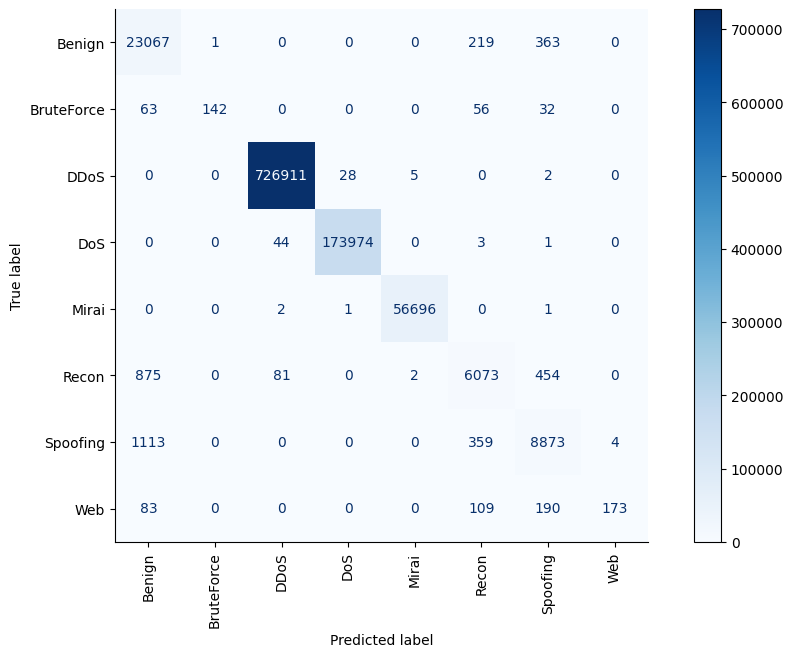

In [11]:
%%time

test_model = RandomForestClassifier(
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = test_df_split

model_utils.train_model(test_model, X_train, y_train)
model_utils.evaluate_model(test_model, X_test, y_test)

### Model without duplicates

In [15]:
%%time

test_df_split = model_utils.get_train_test_split(
    df.drop_duplicates(),
    target='general_label',
    sample_size=5_000_000,
    train_frac=0.80
)

Training dataset size: 4.0M (80.0%).
Test dataset size: 1.0M (20.0%).
CPU times: user 4min 36s, sys: 31.4 s, total: 5min 7s
Wall time: 5min 7s


Execution time (Model fit): 0:01:49.125567
Execution time (Predict): 0:00:02.886750
              precision    recall  f1-score   support

      Benign     0.9152    0.9774    0.9453     39064
  BruteForce     1.0000    0.4793    0.6480       434
        DDoS     0.9997    0.9999    0.9998    625356
         DoS     0.9998    0.9997    0.9997    229134
       Mirai     0.9999    0.9999    0.9999     75332
       Recon     0.8966    0.8218    0.8576     12443
    Spoofing     0.9070    0.8596    0.8827     17351
         Web     0.9735    0.3318    0.4949       886

    accuracy                         0.9935   1000000
   macro avg     0.9615    0.8087    0.8535   1000000
weighted avg     0.9935    0.9935    0.9935   1000000

CPU times: user 48min 4s, sys: 12.5 s, total: 48min 16s
Wall time: 1min 57s


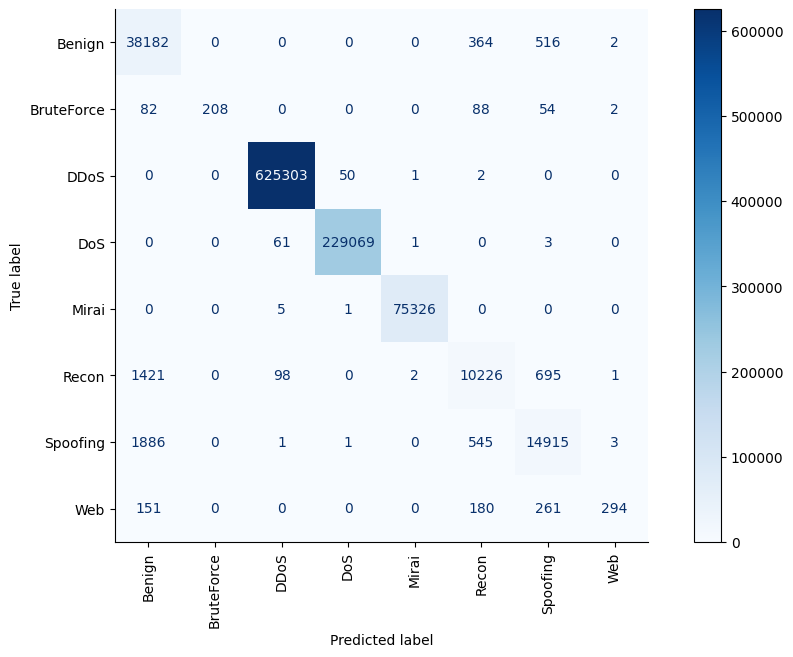

In [16]:
%%time

test_model = RandomForestClassifier(
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = test_df_split

model_utils.train_model(test_model, X_train, y_train)
model_utils.evaluate_model(test_model, X_test, y_test)

### Model without IAT

In [19]:
%%time

test_df_split = model_utils.get_train_test_split(
    df.drop(columns=['IAT']),
    target='general_label',
    sample_size=5_000_000,
    train_frac=0.80
)

Training dataset size: 4.0M (80.0%).
Test dataset size: 1.0M (20.0%).
CPU times: user 18.9 s, sys: 6.47 s, total: 25.3 s
Wall time: 25.3 s


Execution time (Model fit): 0:02:22.128800
Execution time (Predict): 0:00:05.881777
              precision    recall  f1-score   support

      Benign     0.8426    0.9542    0.8949     23710
  BruteForce     0.9286    0.1403    0.2437       278
        DDoS     0.9387    0.9582    0.9484    728000
         DoS     0.8079    0.7379    0.7713    172993
       Mirai     0.9993    0.9959    0.9976     56534
       Recon     0.7734    0.6749    0.7208      7453
    Spoofing     0.8288    0.7125    0.7663     10509
         Web     0.9767    0.0803    0.1484       523

    accuracy                         0.9168   1000000
   macro avg     0.8870    0.6568    0.6864   1000000
weighted avg     0.9168    0.9168    0.9168   1000000

CPU times: user 1h 3min 27s, sys: 18.5 s, total: 1h 3min 46s
Wall time: 2min 34s


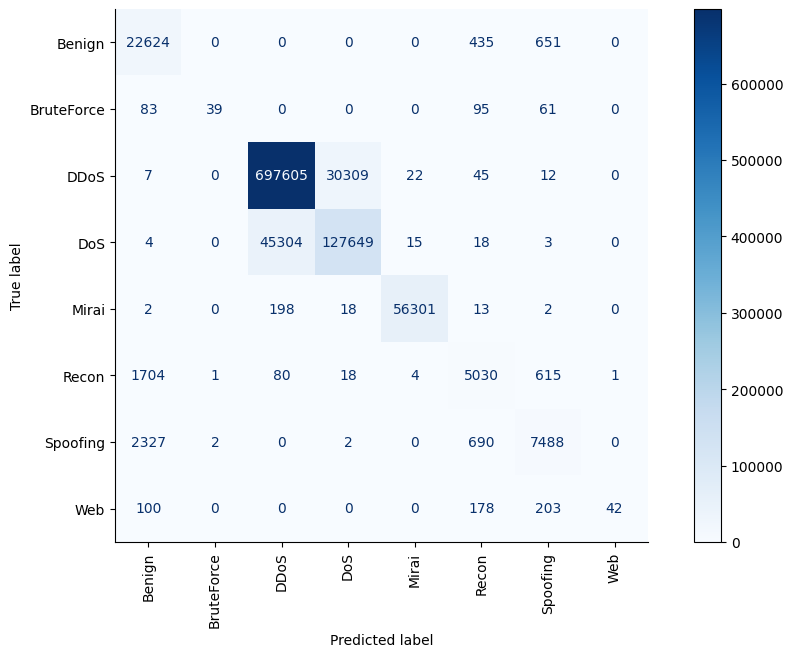

In [20]:
%%time

test_model = RandomForestClassifier(
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = test_df_split

model_utils.train_model(test_model, X_train, y_train)
model_utils.evaluate_model(test_model, X_test, y_test)